<a href="https://colab.research.google.com/github/dmartmillan/DeepLearningSpotNuclei/blob/main/template_final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
import keras.backend as K

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import L2, L1, L1L2

# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks')
# data_loc = '/content/gdrive/My Drive/data'
data_loc = './data'
data_obj = '/data/gent/450/vsc45006'
from data_processing import data_grinder

seed = 2023
np.random.seed(seed)  

## 0. Some functions

In [2]:
def plot_history(history, model_path, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('IoU')
    plt.plot(xvals, np.array(history.history['mean_iou']),'g-', 
             label='Train IoU')
    plt.plot(xvals, np.array(history.history['val_mean_iou']),'r-',
             label = 'Validation IoU')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()
    plt.savefig(model_path + '/results.png')

def iou(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        return iou
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

def diceloss(y_true, y_pred, smooth=1e-6):
    
    #flatten label and prediction tensors
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred))
        dice = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
        return 1 - dice

## 1. Load images

In [3]:
import pickle
data_set = open(f'{data_obj}/data_set.obj', 'rb')
data_dict = pickle.load(data_set)
data_set.close()
train_dict = data_dict['train_dict']
val_dict = data_dict['val_dict']
test_dict = data_dict['test_dict']
data_dict.clear()

## 2. Pre-processing

### 2.1 Procedure

In [4]:
train_set = data_grinder(train_dict)
val_set = data_grinder(val_dict)
train_set.preprocessImages()
val_set.preprocessImages()

2023-05-11 00:37:47.606764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78997 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-05-11 00:37:47.608237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78997 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


### 2.2 Displace images

Image, processed image and mask from data set No. 533 with size (360, 360): c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


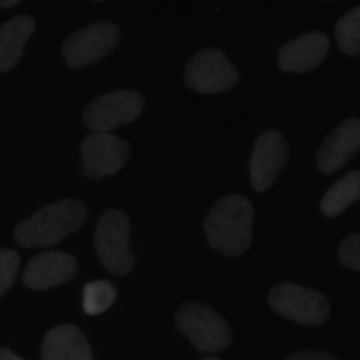

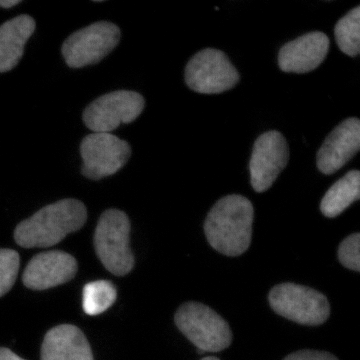

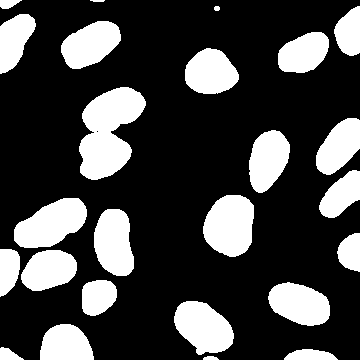

In [5]:
# display
train_set.display_imgs(ix0= 533) # without ix0 input, it will give a random index

## 3. Pre-processing

In [6]:
train_set.croporresizeImages()
val_set.croporresizeImages()

### 3.2 Displace images

Processed image and mask from train set No. 428 with size (256, 256): a3a65623e079af7988b0c1cf1e54041003c6d730c91ecf200b71c47b93a67ed6


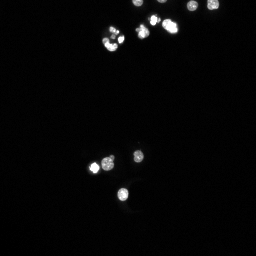

It crops to 4 masks with size (128, 128, 1)
cropped image and mask: 1


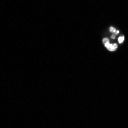

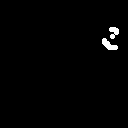

cropped image and mask: 2


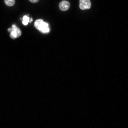

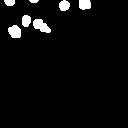

cropped image and mask: 3


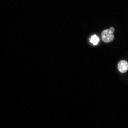

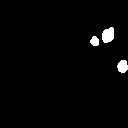

cropped image and mask: 4


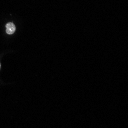

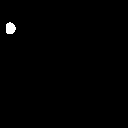

In [7]:
# display
train_set.display_crops() # without ix0 input, it will give a random index

## 4. Test the rejoin function

Image and mask from data set No. 404 with size (256, 256): 9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee
Original image


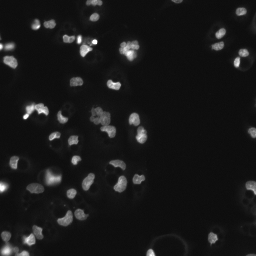

Processed image


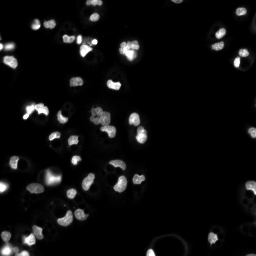

Original mask


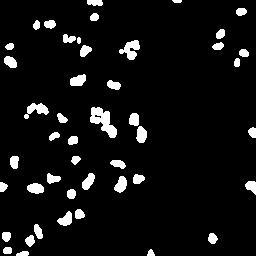

Rejoined mask


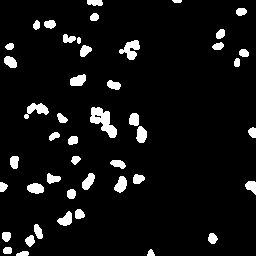

In [8]:
Y_pred_train = train_dict['Y']
train_set.rejoinMask(Y_pred_train)
train_set.display_rejoinmasks() # without ix0 input, it will give a random index

## 5. UNET + ResNet model

### 5.1 Prepare data

In [9]:
train_set.list2array()
val_set.list2array()
X_train0, Y_train = train_set.data_dict['X_array'], train_set.data_dict['Y_array']
X_val0, Y_val = val_set.data_dict['X_array'], val_set.data_dict['Y_array']

 # gray scale only need one value, cause RGB values are the same. you can include all RGB data as well, but have to change the model input dimension as well.
X_train_1 = X_train0[:,:,:,0]/255 # standardization
X_val_1 = X_val0[:,:,:,0]/255
print(f'X_train shape:, {X_train_1.shape}; Y_train shape:, {Y_train.shape}')
print(f'X_val shape:, {X_val_1.shape}; Y_val shape:, {Y_val.shape}')

X_train shape:, (7315, 128, 128); Y_train shape:, (7315, 128, 128, 1)
X_val shape:, (812, 128, 128); Y_val shape:, (812, 128, 128, 1)


In [10]:
X_train_size = len(X_train_1)
X_train = np.zeros((X_train_size, X_train_1.shape[1], X_train_1.shape[2], 3), dtype=np.float32)
for i, x_t in enumerate(X_train_1):
    X_train[i] = np.stack((x_t,)*3, axis=-1)

In [11]:
X_val_size = len(X_val_1)
X_val = np.zeros((X_val_size, X_val_1.shape[1], X_val_1.shape[2], 3), dtype=np.float32)
for i, x_v in enumerate(X_val_1):
    X_val[i] = np.stack((x_v,)*3, axis=-1)

### 5.2 Model setup

In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.2)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.5)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    #x = UpSampling2D()(input)
    #x = Conv2D(num_filters, 2, activation='relu', padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [13]:
def UNet_ResNet(inputs_shape, LR):
    
    inputs = Input(inputs_shape, name="input")
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    resnet50.trainable = False
    
    # Encoder
    s1 = resnet50.get_layer("input").output             # (128 x 128) 3
    s2 = resnet50.get_layer("conv1_relu").output        # (64 x 64) 64
    s3 = resnet50.get_layer("conv2_block3_out").output  # (32 x 32) 256
    s4 = resnet50.get_layer("conv3_block4_out").output  # (16 x 16) 512
    
    
    # Bridge
    b1 = resnet50.get_layer("conv4_block6_out").output  # (8 x 8) 1024
    
    # Decoder
    d1 = decoder_block(b1, s4, 512)                     # (16 x 16)
    d2 = decoder_block(d1, s3, 256)                      # (32 x 32)
    d3 = decoder_block(d2, s2, 128)                      # (64 x 64)
    d4 = decoder_block(d3, s1, 64)                      # (128 x 128)
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    
    model = keras.models.Model(inputs, outputs)
    
    model.compile(loss=diceloss,
                  optimizer=Adam(learning_rate=LR),
                  metrics=[mean_iou])
    
    return model

### 5.3 Parameters

In [14]:
batch_size = 128
batches_per_epoch = int(len(X_train)/batch_size) 
epochs = 100
LR = 0.001
stopping_patience = 10
stopping_delta = 0.001

model = UNet_ResNet((128,128,3), LR)
model.compile(loss=diceloss, optimizer=Adam(learning_rate=LR), metrics=[mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

### 5.4 Training

In [15]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou',
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

results = model.fit(X_train, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,  
                    validation_data=(X_val, Y_val),
                    callbacks = [stopping_callback],
                    shuffle=True)

Epoch 1/100


2023-05-11 00:39:48.294601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


58/58 [==============================] - 47s 390ms/step - loss: 0.3708 - mean_iou: 0.5766 - val_loss: 0.5825 - val_mean_iou: 0.5611
Epoch 2/100
58/58 [==============================] - 20s 349ms/step - loss: 0.2705 - mean_iou: 0.6763 - val_loss: 0.4387 - val_mean_iou: 0.4836
Epoch 3/100
58/58 [==============================] - 20s 347ms/step - loss: 0.2581 - mean_iou: 0.6816 - val_loss: 0.3015 - val_mean_iou: 0.6580
Epoch 4/100
58/58 [==============================] - 20s 348ms/step - loss: 0.2501 - mean_iou: 0.6928 - val_loss: 0.2844 - val_mean_iou: 0.6579
Epoch 5/100
58/58 [==============================] - 20s 347ms/step - loss: 0.2448 - mean_iou: 0.6956 - val_loss: 0.2914 - val_mean_iou: 0.5207
Epoch 6/100
58/58 [==============================] - 20s 347ms/step - loss: 0.2351 - mean_iou: 0.7040 - val_loss: 0.3205 - val_mean_iou: 0.5913
Epoch 7/100
58/58 [==============================] - 20s 348ms/step - loss: 0.2260 - mean_iou: 0.6971 - val_loss: 0.7653 - val_mean_iou: 0.2255
Epoc

### 5.5 Model evaluation

In [16]:
model_savepath = "/data/gent/450/vsc45006/model9"  
model.save(model_savepath)

2023-05-11 00:47:12.038104: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /data/gent/450/vsc45006/model9/assets


/apps/gent/RHEL8/zen3-ampere-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/apps/gent/RHEL8/zen3-ampere-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Training set IoU: 0.8256
Training set Loss:0.190067

Validation set IoU: 0.7642
Validation set Loss:0.223099



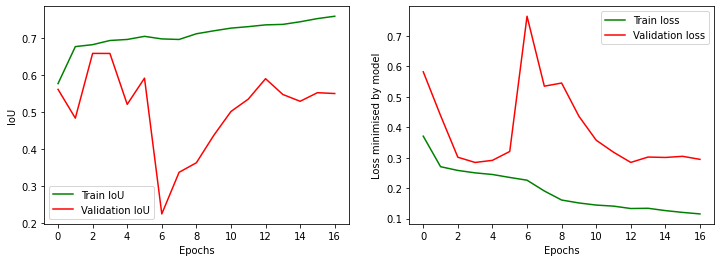

In [17]:
[train_IoU, train_loss] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_IoU))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_IoU, val_loss] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_IoU))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(results, model_savepath)

In [18]:
preds_train = model.predict(X_train, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)

229/229 [==============================] - 7s 28ms/step


In [19]:
preds_val = model.predict(X_val, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

26/26 [==============================] - 1s 28ms/step


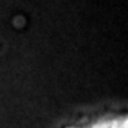

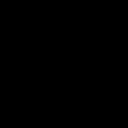

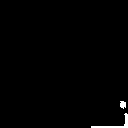

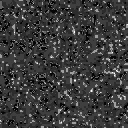

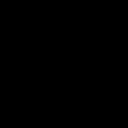

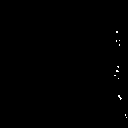

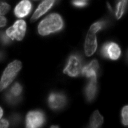

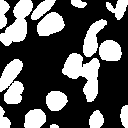

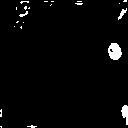

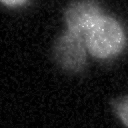

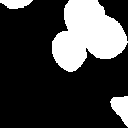

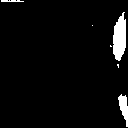

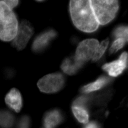

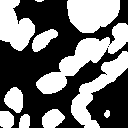

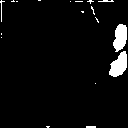

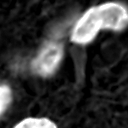

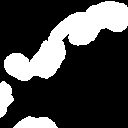

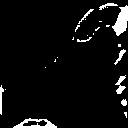

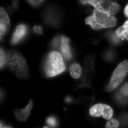

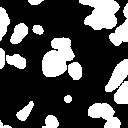

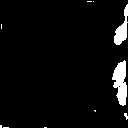

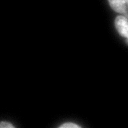

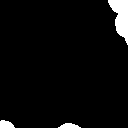

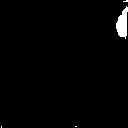

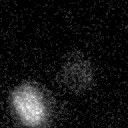

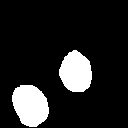

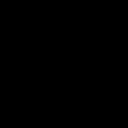

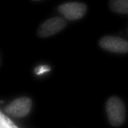

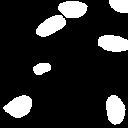

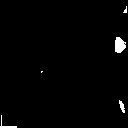

In [20]:
ix = random.randint(0, len(preds_val_t))
for i in range(10):
    ix = random.randint(0, len(preds_val_t))
    display(keras.preprocessing.image.array_to_img(X_val0[ix]*255))
    keras.preprocessing.image.array_to_img(X_val0[ix]*255).save(f'{model_savepath}/{i}-img-val.png')
        
    display(keras.preprocessing.image.array_to_img(Y_val[ix]))
    keras.preprocessing.image.array_to_img(Y_val[ix]).save(f'{model_savepath}/{i}-mask-val.png')
        
    display(keras.preprocessing.image.array_to_img(preds_val_t[ix]))
    keras.preprocessing.image.array_to_img(preds_val_t[ix]).save(f'{model_savepath}/{i}-predict.png')

### 5.6 Calculate IoU for Validation set

In [21]:
train_set.rejoinMask(preds_train)
val_set.rejoinMask(preds_val)

train_set.cal_iou()
print("Train set IoU:{:7.4f}".format(train_set.mean_iou))
val_set.cal_iou()
print("Validation set IoU:{:7.4f}".format(val_set.mean_iou))

Train set IoU: 0.1040
Validation set IoU: 0.1264


### 5.7 Test evaluation (to be updated)

In [ ]:
test_set = data_grinder(test_dict)
test_set.preprocessImages()
test_set.croporresizeImages(hasmask = False)
test_set.list2array()
X_test0 = test_set.data_dict['X_array']

X_test = X_test0[:,:,:,0]/255 # standardization

In [ ]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
test_set.rejoinMask(preds_test)

1335/1335 [==============================] - 33s 25ms/step


In [ ]:
imageIDs = test_set.data_dict['imageIDs']
ix = random.randint(0, len(imageIDs) - 1)
display(test_set.data_dict['images'][ix])
display(test_set.data_dict['cal_masks'][ix])

## 6. Export to EXCEL